# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
df_gen = azdias.copy()
df_gen.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.

# Number of naturally missing values
n_natural_missing = df_gen.isnull().sum()

In [5]:
# Split the string in feat_info
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].str.strip('][').str.split(pat= ',')

In [6]:
# Convert the numeric string in feat_info to float
def maybe_float(s):
    try:
        return float(s)
    except (ValueError, TypeError):
        return s
    
for i in range(len(feat_info)):
    missing = feat_info.iloc[i,3]
    feat_info.iloc[i,3] = [maybe_float(x) for x in missing]
    
feat_info.head()

    

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1.0, 0.0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1.0, 0.0, 9.0]"
2,ANREDE_KZ,person,categorical,"[-1.0, 0.0]"
3,CJT_GESAMTTYP,person,categorical,[0.0]
4,FINANZ_MINIMALIST,person,ordinal,[-1.0]


In [7]:
# Identify missing or unknown values and replace by NaN
for att in list(azdias.columns):
    to_replace = feat_info[feat_info['attribute'] == att]['missing_or_unknown'].values[0]
    df_gen.loc[df_gen[att].isin(to_replace),att] = np.nan

In [8]:
df_gen.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

n_nan_gen = df_gen.isnull().sum()

In [10]:
# Investigate the features
n_nan_gen.reset_index().groupby(0)['index'].value_counts()

0       index                
0       ANREDE_KZ                1
        FINANZTYP                1
        FINANZ_ANLEGER           1
        FINANZ_HAUSBAUER         1
        FINANZ_MINIMALIST        1
        FINANZ_SPARER            1
        FINANZ_UNAUFFAELLIGER    1
        FINANZ_VORSORGER         1
        GREEN_AVANTGARDE         1
        SEMIO_DOM                1
        SEMIO_ERL                1
        SEMIO_FAM                1
        SEMIO_KAEM               1
        SEMIO_KRIT               1
        SEMIO_KULT               1
        SEMIO_LUST               1
        SEMIO_MAT                1
        SEMIO_PFLICHT            1
        SEMIO_RAT                1
        SEMIO_REL                1
        SEMIO_SOZ                1
        SEMIO_TRADV              1
        SEMIO_VERT               1
        ZABEOTYP                 1
2881    ALTERSKATEGORIE_GROB     1
4854    CJT_GESAMTTYP            1
        GFK_URLAUBERTYP          1
        LP_STATUS_FEIN   

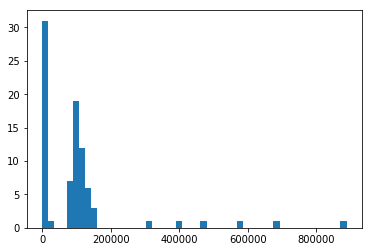

In [11]:
# Investigate patterns in the amount of missing data in each column.
fig, ax = plt.subplots()
ax.hist(n_nan_gen, bins = 50)
plt.show()

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
col_drop = list(n_nan_gen[n_nan_gen > 300000].index)
print('Outlier columns are :\n', col_drop)

df_col_drop = df_gen.drop(col_drop, axis = 1)
print('\nIs dropping column correctly implemented?',len(df_col_drop.columns) == (df_gen.shape[1]-len(col_drop)))


Outlier columns are :
 ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

Is dropping column correctly implemented? True


#### Discussion 1.1.2: Assess Missing Data in Each Column

- The amount of missing data for all features vary from 2881 to 889061.

- The features with same prefixes often have the same amount of missing values.

- The features `AGER_TYP`, `GEBURTSJAHR`, `TITEL_KZ`, `ALTER_HH`, `KK_KUNDENTYP` and `KBA05_BAUMAX` are identified as outlier columns because there are at least 300000 missing values compared to other columns with around 100000 missing values.

- Note that these features may be re-encoded to include, while in this project, we drop them for simplicity.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [13]:
# How much data is missing in each row of the dataset?
n_nan_row_df_col_drop = df_col_drop.isnull().sum(axis = 1)
print('Maximum number of missing values in each row is {}.\n'.format(n_nan_row_df_col_drop.max()))
print('Amount of missing values vs Number of rows\n')
print(n_nan_row_df_col_drop.value_counts().sort_index())

Maximum number of missing values in each row is 49.

Amount of missing values vs Number of rows

0     623209
1      15738
2      27926
3      17629
4      12607
5      22515
6      13771
7      13714
8      24592
9       3042
10      5410
11      1127
12       766
13      3255
14      2243
15      4743
16      2505
17       677
18       428
19      1180
20       349
21       150
22       129
23       132
24        69
25        55
26        59
27        24
28         5
29        12
30         6
31         3
32       206
33      2985
34     10816
35      3911
36        84
37       538
38       421
39        77
40       137
41       356
42        21
43     27369
44       155
45       494
47     45578
48         1
49         2
dtype: int64


In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 0

#few_null_ind = df_col_drop_row_null<=threshold
#more_null_ind = df_col_drop_row_null >threshold

#df_few_null_subset = 
#df_more_null_subset = 

df_no_nan = df_col_drop[n_nan_row_df_col_drop <= threshold]
df_more_nan = df_col_drop[n_nan_row_df_col_drop  > threshold]


In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_plot(df_few_nan, df_more_nan, col_name):
    fig, axes = plt.subplots(1,2, figsize = (9,3))
    sns.countplot(ax = axes[0], y = df_few_nan[col_name])
    sns.countplot(ax = axes[1], y = df_more_nan[col_name])
    plt.show()
def common_ele(list1, list2):
    return list(set(list1) & set(list2))

col_names = list(df_col_drop)

common_col_no_nan = common_ele(list(df_col_drop.columns[df_no_nan.isnull().sum() ==0]), 
                               list(df_col_drop.columns[df_more_nan.isnull().sum() ==0]))

#common_col_no_nan = list(set(col_names[df_no_nan.isnull().sum() == 0]) & set())
#few_null_full_cols = df_col_drop.columns[df_few_null_subset.isnull().sum() ==0]
#more_null_full_cols = df_col_drop.columns[df_more_null_subset.isnull().sum() ==0]
#subset_full_col = list(set(few_null_full_cols) & set(more_null_full_cols))


In [16]:
print('There are {} columns with no missing values for both subsets:\n {}'.format(len(common_col_no_nan), common_col_no_nan))

There are 24 columns with no missing values for both subsets:
 ['FINANZ_UNAUFFAELLIGER', 'ANREDE_KZ', 'FINANZ_VORSORGER', 'SEMIO_DOM', 'SEMIO_KRIT', 'SEMIO_MAT', 'SEMIO_LUST', 'SEMIO_VERT', 'SEMIO_SOZ', 'SEMIO_KULT', 'SEMIO_ERL', 'SEMIO_FAM', 'GREEN_AVANTGARDE', 'SEMIO_RAT', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'FINANZ_HAUSBAUER', 'SEMIO_REL', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_ANLEGER', 'FINANZTYP', 'ZABEOTYP', 'SEMIO_KAEM']


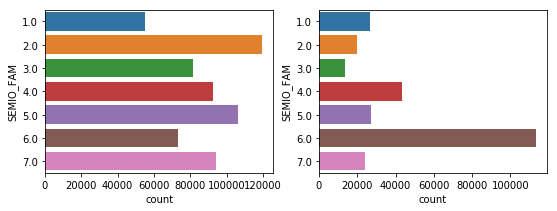

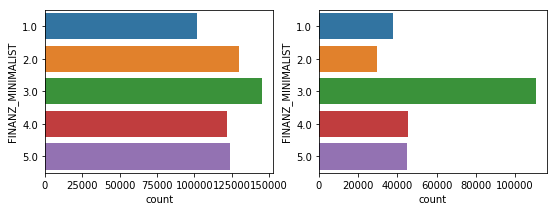

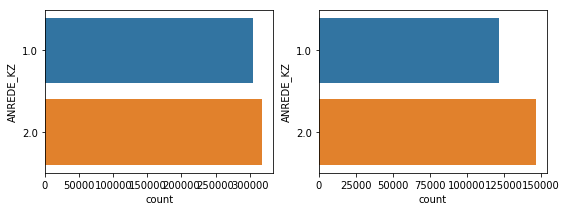

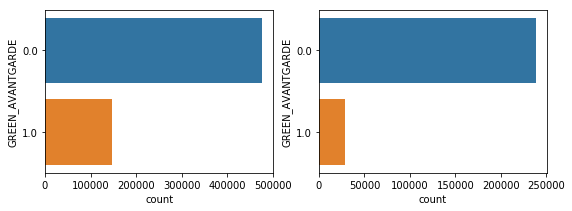

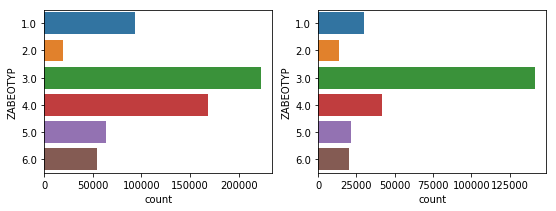

In [17]:
five_cols = ['SEMIO_FAM', 'FINANZ_MINIMALIST', 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'ZABEOTYP']
for col in five_cols:
    compare_plot(df_no_nan, df_more_nan,col)

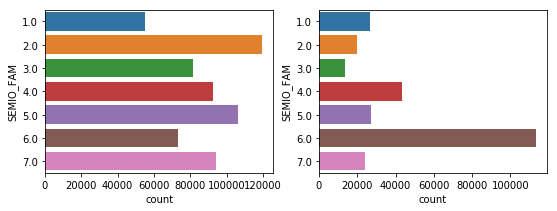

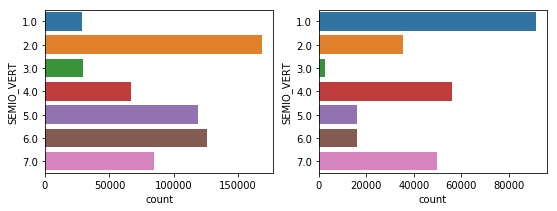

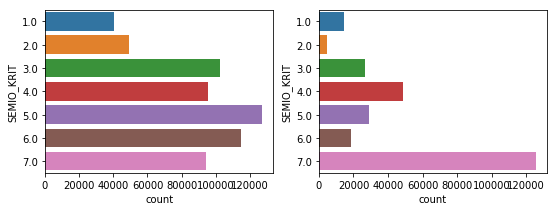

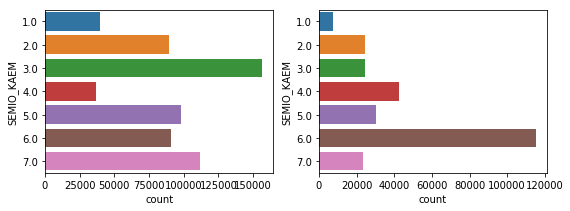

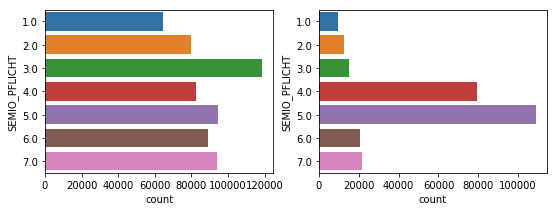

In [18]:
# Investigate more on features with prefix 'SEMIO'
SEMIO_cols = ['SEMIO_FAM', 'SEMIO_VERT', 'SEMIO_KRIT', 'SEMIO_KAEM', 'SEMIO_PFLICHT']
for col in SEMIO_cols:
    compare_plot(df_no_nan, df_more_nan, col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

- The threshold on the amount of missing values is set to 0.

- The first five columns chosen are `SEMIO_FAM`, `FINANZ_MINIMALIST`,`ANREDE_KZ`, `GREEN_AVANTGARDE`, `ZABEOTYP`, which have different prefixes.
- We observe that two subsets vary in column 'SEMIO_FAM' and do not have big different among other colums qualitatively.

- Thus, we further investigate another five columns with the same prefix 'SEMIO'.
    - The second five columns chosen are `SEMIO_FAM`, `SEMIO_VERT`, `SEMIO_KRIT`, `SEMIO_KAEM`, `SEMIO_PFLICHT`.
    - We observe that two subsets indeed have different distributions of these features.

- For this project, we will drop the columns with missing values, however, these columns with 'SEMIO' prefix should be remembered to be special.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?
feat_info['type'].value_counts()


ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# The data is assessed after dropping columns in Discussion 1.1.2
cat_feat_attr = feat_info[feat_info['type'] =='categorical']['attribute']
cat_feat_attr_df_no_nan = list(df_no_nan.columns)

cat_feat_attr_left = common_ele(cat_feat_attr, cat_feat_attr_df_no_nan)

cat_feat_df_no_nan = pd.DataFrame(cat_feat_attr_left, columns = ['attribute'])

values = []
levels = []
for  cat_attr in cat_feat_df_no_nan['attribute']:
    val_unique = df_no_nan[cat_attr].unique()
    values.append(val_unique)
    levels.append(len(val_unique))
cat_feat_df_no_nan['levels'] = levels
cat_feat_df_no_nan['values']  = values
 
print('There are {} categorical features after moving columns in Discussion 1.1.2\n'.format(len(cat_feat_df_no_nan)))
display(cat_feat_df_no_nan)


There are 18 categorical features after moving columns in Discussion 1.1.2



,attribute,levels,values
0,VERS_TYP,2,"[2.0, 1.0]"
1,CJT_GESAMTTYP,6,"[5.0, 3.0, 2.0, 4.0, 1.0, 6.0]"
2,GFK_URLAUBERTYP,12,"[10.0, 5.0, 1.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4...."
3,LP_STATUS_GROB,5,"[1.0, 2.0, 5.0, 4.0, 3.0]"
4,ANREDE_KZ,2,"[2.0, 1.0]"
5,NATIONALITAET_KZ,3,"[1.0, 2.0, 3.0]"
6,LP_STATUS_FEIN,10,"[2.0, 3.0, 4.0, 1.0, 10.0, 9.0, 5.0, 6.0, 7.0,..."
7,OST_WEST_KZ,2,"[W, O]"
8,LP_FAMILIE_GROB,5,"[3.0, 1.0, 5.0, 2.0, 4.0]"
9,FINANZTYP,6,"[1.0, 5.0, 2.0, 4.0, 6.0, 3.0]"


In [21]:
# Keep the categorical features with at most 4 features

cat_drop  = list(cat_feat_df_no_nan[cat_feat_df_no_nan['levels']>4]['attribute'])
cat_keep = list(cat_feat_df_no_nan[cat_feat_df_no_nan['levels']<=4]['attribute'])
df_cat_drop = df_no_nan.drop(cat_drop, axis = 1)


print('Check whether the categorical features are correctly selected:\n {}'.format( common_ele(list(df_cat_drop.columns), cat_keep)))

cat_keep

Check whether the categorical features are correctly selected:
 ['VERS_TYP', 'ANREDE_KZ', 'NATIONALITAET_KZ', 'OST_WEST_KZ', 'GEBAEUDETYP', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'SHOPPER_TYP']


['VERS_TYP',
 'ANREDE_KZ',
 'NATIONALITAET_KZ',
 'OST_WEST_KZ',
 'GEBAEUDETYP',
 'GREEN_AVANTGARDE',
 'SOHO_KZ',
 'SHOPPER_TYP']

In [22]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Binary variables
binary_cat = list(cat_feat_df_no_nan[cat_feat_df_no_nan['levels']==2]['attribute'])
cat_feat_df_no_nan[cat_feat_df_no_nan['attribute'].isin(binary_cat)]

,attribute,levels,values
0,VERS_TYP,2,"[2.0, 1.0]"
4,ANREDE_KZ,2,"[2.0, 1.0]"
7,OST_WEST_KZ,2,"[W, O]"
12,GREEN_AVANTGARDE,2,"[0.0, 1.0]"
14,SOHO_KZ,2,"[1.0, 0.0]"


In [23]:
binary_to_encode= ['VERS_TYP', 'ANREDE_KZ', 'OST_WEST_KZ']
binary_encode = [{2.0:1, 1.0:0},{2.0:1, 2.0:0},{'W': 1, 'O': 0}]

for i, binary_feat in enumerate(binary_to_encode):
    df_cat_drop[binary_feat] = df_cat_drop[binary_feat].replace(binary_encode[i])
df_cat_drop[binary_to_encode].head()

,VERS_TYP,ANREDE_KZ,OST_WEST_KZ
1,1.0,0.0,1
2,0.0,0.0,1
4,1.0,1.0,1
5,1.0,0.0,1
6,0.0,0.0,1


In [24]:
# Re-encode multi-level features by one-hotcoding
multi_to_encode = list(cat_feat_df_no_nan[(cat_feat_df_no_nan['levels']>2) & (cat_feat_df_no_nan['levels']<=4)]['attribute'])
df_encode = pd.concat([df_cat_drop, pd.get_dummies(df_cat_drop[multi_to_encode].astype(str))], axis = 1).drop(multi_to_encode, axis = 1)

In [25]:
multi_to_encode

['NATIONALITAET_KZ', 'GEBAEUDETYP', 'SHOPPER_TYP']

In [26]:
df_encode.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,GEBAEUDETYP_1.0,GEBAEUDETYP_3.0,GEBAEUDETYP_5.0,GEBAEUDETYP_8.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0
1,1.0,0.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0,0,0,0,0,1,0,0,0,1
2,3.0,0.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0,0,1,0,0,0,0,0,1,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0,0,1,0,0,0,0,0,1,0
5,1.0,0.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0,0,1,0,0,0,1,0,0,0
6,2.0,0.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,0,0,1,0,0,0,0,1,0,0


In [27]:
df_encode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623209 entries, 1 to 891220
Data columns (total 77 columns):
ALTERSKATEGORIE_GROB     623209 non-null float64
ANREDE_KZ                623209 non-null float64
FINANZ_MINIMALIST        623209 non-null float64
FINANZ_SPARER            623209 non-null float64
FINANZ_VORSORGER         623209 non-null float64
FINANZ_ANLEGER           623209 non-null float64
FINANZ_UNAUFFAELLIGER    623209 non-null float64
FINANZ_HAUSBAUER         623209 non-null float64
GREEN_AVANTGARDE         623209 non-null float64
HEALTH_TYP               623209 non-null float64
LP_LEBENSPHASE_FEIN      623209 non-null float64
LP_LEBENSPHASE_GROB      623209 non-null float64
PRAEGENDE_JUGENDJAHRE    623209 non-null float64
RETOURTYP_BK_S           623209 non-null float64
SEMIO_SOZ                623209 non-null float64
SEMIO_FAM                623209 non-null float64
SEMIO_REL                623209 non-null float64
SEMIO_MAT                623209 non-null float64
SEMIO_V

#### Discussion 1.2.1: Re-Encode Categorical Features

- After dropping the columns in Discussion 1.1.2, there are 18 categorical features left, among which `GREEN_AVANTGARDE`, `OST_WEST_KZ`, `SOHO_KZ`, `ANREDE_KZ` and `VERS_TYP` are binary features.

- We keep the binary feature and three multi-level features which have at most 4 levels (`SHOPPER_TYP`, `GEBAEUDETYP`, `NATIONALITAET_KZ`).

- We re-encode binary features with 0-1 dummy variables
- We re-encode multi-level features with one-hotcoding.

- Finally, we have 77 features.




#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
# Show the mixed features
mixed_attr = common_ele(list(feat_info[feat_info['type'] =='mixed']['attribute']), list(df_encode.columns))
feat_info[feat_info['attribute'].isin(mixed_attr)]

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0.0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0.0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1.0, 0.0]"
56,WOHNLAGE,building,mixed,[-1.0]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1.0, XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1.0, 0.0]"


In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# move_map: 0: Mainstream; 1:Avantgarde
move_map = {1:0, 2:1, 3: 0, 4:1, 5:0, 6: 1, 7: 1, 
            8: 0, 9: 1, 10:0, 11:1, 12: 0, 13:1, 14:0, 15:1 }

df_mixed = df_encode.copy()

PRAEG_data = df_mixed["PRAEGENDE_JUGENDJAHRE" ].astype(int)

df_mixed['GENERATION'] = pd.cut(df_mixed["PRAEGENDE_JUGENDJAHRE"], bins = [0,2,4,7,9,13,15], labels = [40, 50, 60, 70, 80, 90])
#df_mixed['GENERATION'] = PRAEG_data.map(gen_map)
df_mixed['MOVEMENT'] = PRAEG_data.map(move_map)
df_mixed.head()



,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_1.0,GEBAEUDETYP_3.0,GEBAEUDETYP_5.0,GEBAEUDETYP_8.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,GENERATION,MOVEMENT
1,1.0,0.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0,0,0,1,0,0,0,1,90,0
2,3.0,0.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,1,0,0,0,0,0,1,0,90,1
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1,0,0,0,0,0,1,0,70,0
5,1.0,0.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1,0,0,0,1,0,0,0,50,0
6,2.0,0.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,1,0,0,0,0,1,0,0,80,0


In [30]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def wealth_life_map(x):
    life = int(x)%10
    wealth = int(x)//10%10
    return wealth, life
    
encode_list = np.array( [list(x) for x in list(map(wealth_life_map, df_mixed['CAMEO_INTL_2015']))])
df_mixed['WEALTH'] = encode_list[:,0]
df_mixed['LIFESTAGE'] = encode_list[:,1]

df_mixed['CAMEO_INTL_2015'].head()

1    51
2    24
4    43
5    54
6    22
Name: CAMEO_INTL_2015, dtype: object

In [31]:
df_mixed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_5.0,GEBAEUDETYP_8.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,GENERATION,MOVEMENT,WEALTH,LIFESTAGE
1,1.0,0.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0,1,0,0,0,1,90,0,5,1
2,3.0,0.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0,0,0,0,1,0,90,1,2,4
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0,0,0,0,1,0,70,0,4,3
5,1.0,0.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0,0,1,0,0,0,50,0,5,4
6,2.0,0.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,0,0,0,1,0,0,80,0,2,2


In [32]:
# Investigate other mixed features
len_mixed = [len(df_mixed[att].unique()) for att in mixed_attr]
print(list(zip(mixed_attr, len_mixed)))



[('LP_LEBENSPHASE_GROB', 12), ('PRAEGENDE_JUGENDJAHRE', 15), ('LP_LEBENSPHASE_FEIN', 40), ('CAMEO_INTL_2015', 21), ('WOHNLAGE', 8), ('PLZ8_BAUMAX', 5)]


In [33]:
mixed_drop = ['LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN']
df_clean = df_mixed.drop(mixed_drop, axis = 1)
df_clean.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis = 1, inplace =True)
df_clean = df_clean.reset_index(drop = True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

- We investigate all the mixed type features, in addition to `CAMEO_INTL_2015`,`PRAEGENDE_JUGENDJAHRE`, we keep `WOHNLAGE` and `PLZ8_BAUMAX` because their number of levels are about 5-8 which are relatively low.

- We drop `LP_LEBENSPHASE_GROB` and `LP_LEBENSPHASE_FEIN` because they have so many levels, which may affect the analysis without considering the ordinal difference.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [34]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623209 entries, 0 to 623208
Data columns (total 77 columns):
ALTERSKATEGORIE_GROB     623209 non-null float64
ANREDE_KZ                623209 non-null float64
FINANZ_MINIMALIST        623209 non-null float64
FINANZ_SPARER            623209 non-null float64
FINANZ_VORSORGER         623209 non-null float64
FINANZ_ANLEGER           623209 non-null float64
FINANZ_UNAUFFAELLIGER    623209 non-null float64
FINANZ_HAUSBAUER         623209 non-null float64
GREEN_AVANTGARDE         623209 non-null float64
HEALTH_TYP               623209 non-null float64
RETOURTYP_BK_S           623209 non-null float64
SEMIO_SOZ                623209 non-null float64
SEMIO_FAM                623209 non-null float64
SEMIO_REL                623209 non-null float64
SEMIO_MAT                623209 non-null float64
SEMIO_VERT               623209 non-null float64
SEMIO_LUST               623209 non-null float64
SEMIO_ERL                623209 non-null float64
SEMIO_K

In [35]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
for col in list(df_clean.columns):
        df_clean[col] = df_clean[col].astype(float)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623209 entries, 0 to 623208
Data columns (total 77 columns):
ALTERSKATEGORIE_GROB     623209 non-null float64
ANREDE_KZ                623209 non-null float64
FINANZ_MINIMALIST        623209 non-null float64
FINANZ_SPARER            623209 non-null float64
FINANZ_VORSORGER         623209 non-null float64
FINANZ_ANLEGER           623209 non-null float64
FINANZ_UNAUFFAELLIGER    623209 non-null float64
FINANZ_HAUSBAUER         623209 non-null float64
GREEN_AVANTGARDE         623209 non-null float64
HEALTH_TYP               623209 non-null float64
RETOURTYP_BK_S           623209 non-null float64
SEMIO_SOZ                623209 non-null float64
SEMIO_FAM                623209 non-null float64
SEMIO_REL                623209 non-null float64
SEMIO_MAT                623209 non-null float64
SEMIO_VERT               623209 non-null float64
SEMIO_LUST               623209 non-null float64
SEMIO_ERL                623209 non-null float64
SEMIO_K

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [36]:
# Split the string in feat_info and transform data to float if necessary

def feat_info_transform(feat_info):
    # Split the string in feat_info
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].str.strip('][').str.split(pat= ',')
    
    for i in range(len(feat_info)):
        missing = feat_info.iloc[i,3]
        feat_info.iloc[i,3] = [maybe_float(x) for x in missing]
    return feat_info

def clean_data(data):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    df = data.copy()
    # Convert numeric strings in 'AZDIAS_Feature_Summary.csv' into float
    feat_info_original = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
    feat_info = feat_info_transform(feat_info_original)
    
    # convert missing value codes into NaNs, ...
    for att in list(df.columns):
        to_replace = feat_info[feat_info['attribute'] == att]['missing_or_unknown'].values[0]
        df.loc[df[att].isin(to_replace),att] = np.nan
    
    # remove selected columns
    col_drop = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    
    df.drop(col_drop, axis = 1, inplace = True)
    
    # remove missing rows
    df.dropna(inplace = True)
    
    # select, re-encode, and engineer column values.
    
    # Drop categorical features and re-encode
    
    cat_drop  = ['CJT_GESAMTTYP','ZABEOTYP','GFK_URLAUBERTYP','LP_STATUS_GROB','FINANZTYP','LP_FAMILIE_GROB', 'LP_STATUS_FEIN' ,'CAMEO_DEU_2015', 'CAMEO_DEUG_2015' ,'LP_FAMILIE_FEIN']
    binary_cat = ['GREEN_AVANTGARDE', 'OST_WEST_KZ', 'SOHO_KZ', 'ANREDE_KZ', 'VERS_TYP']
    
    multi_to_encode =['SHOPPER_TYP', 'GEBAEUDETYP', 'NATIONALITAET_KZ']
    
    binary_to_encode= ['VERS_TYP', 'ANREDE_KZ', 'OST_WEST_KZ']
    binary_encode = [{2.0:1, 1.0:0},{2.0:1, 2.0:0},{'W': 1, 'O': 0}]
    
    df.drop(cat_drop, axis = 1, inplace= True)
    
    for i, binary_feat in enumerate(binary_to_encode):
        df[binary_feat] = df[binary_feat].replace(binary_encode[i])


    df = pd.concat([df, pd.get_dummies(df[multi_to_encode].astype(str))], axis = 1).drop(multi_to_encode, axis = 1)
    
    # Drop mixed features and re-encode
    
    mixed_drop = ['LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN']
    df.drop(mixed_drop, axis = 1, inplace = True)
    

    move_map = {1:0, 2:1, 3: 0, 4:1, 5:0, 6: 1, 7: 1, 
                8: 0, 9: 1, 10:0, 11:1, 12: 0, 13:1, 14:0, 15:1 }

    PRAEG_data = df["PRAEGENDE_JUGENDJAHRE" ].astype(int)
    df['GENERATION'] = pd.cut(df["PRAEGENDE_JUGENDJAHRE"], bins = [0,2,4,7,9,13,15], labels = [40, 50, 60, 70, 80, 90])
    df['MOVEMENT'] = PRAEG_data.map(move_map)
    
    encode_list = np.array( [list(x) for x in list(map(wealth_life_map, df['CAMEO_INTL_2015']))])
    df['WEALTH'] = encode_list[:,0]
    df['LIFESTAGE'] = encode_list[:,1]
    
    # Drop the original mixed feature before re-enconde
    df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis = 1, inplace = True)
    df = df.reset_index(drop = True)
    # Change the datatype to floate64
    for col in list(df.columns):
        df[col] = df.astype(float)
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [37]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

**The rows with missing values have been dropped.**

In [38]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

# scaled_df will be used later for transforming the customer data
#ss_fit = ss.fit(df_clean)
scaled_df = ss.fit_transform(df_clean)



### Discussion 2.1: Apply Feature Scaling

- The missing values have been dropped when doing step 1.1.3.
- Note has been taken that features named 'SEMIO.....' may have different distributions for data with missing values and data with no missing values.

- The features have been standardized and stored in `scaled_df` and the StandardScaler is stored as `ss`, which can be used for fit and tranforming the customer data later.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [39]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
n_comp = int(scaled_df.shape[1]/2)+5
pca = PCA(n_components = n_comp)
scaled_df_pca = pca.fit_transform(scaled_df)


Text(0.5,1,'Explained Variance Per Principal Component')

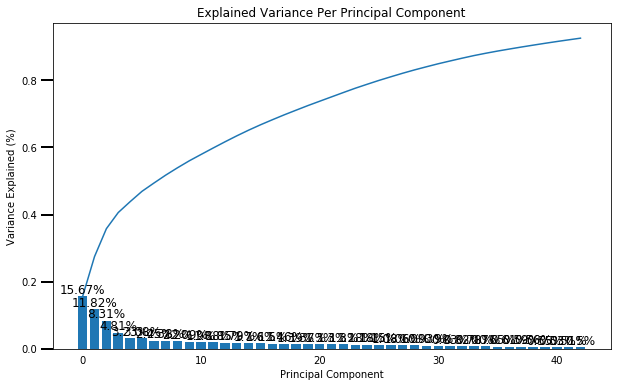

In [40]:
# Investigate the variance accounted for by each principal component.
y_ratio = pca.explained_variance_ratio_
y_cum_ratio = np.cumsum(y_ratio)

n_components = len(y_ratio)
x = np.arange(n_components)

fig, ax = plt.subplots(figsize = (10,6))
ax.bar(x, y_ratio)
ax.plot(x, y_cum_ratio)

for i, y in zip(x, y_ratio):
    ax.annotate(r'%s%%' % (str(round(y*100,2))),
                (i,y), va = 'bottom', ha = 'center', fontsize = 12)
ax.xaxis.set_tick_params(width = 0)
ax.yaxis.set_tick_params(width = 2, length = 12)

ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained (%)')
plt.title('Explained Variance Per Principal Component')



In [41]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_comp_reapply = 40
pca_reapply = PCA(n_components = n_comp_reapply)
scaled_df_pca_reapply = pca_reapply.fit_transform(scaled_df)

### Discussion 2.2: Perform Dimensionality Reduction

We implement principle component analysis for the first 43 principle components.
In the screeplot, we observed that the first six components explain about 40% of the variance and the first 40 components explain over 80% of the variance.

Thus, we retain the first 40 principal components for the next step of the analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [42]:
def sort_component(feat_names, pca, comp_ind):
    if comp_ind < len(pca.components_):
        weights = pca.components_[comp_ind]
        features_sort = list(feat_names[np.argsort(weights)])
        weights_sort = list(np.sort(weights))
        df = pd.DataFrame({'features_sort': features_sort,
                          'weights_sort': weights_sort})
        return df
    else:
        print('Incorrect comp_ind')

In [43]:
# Record the feature names from the dataset
feat_names = np.array(list(df_clean.columns))

In [44]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

pca_feat_1 = sort_component(feat_names, pca_reapply, 0)
pca_feat_1


,features_sort,weights_sort
0,MOBI_REGIO,-0.228741
1,PLZ8_ANTG1,-0.215324
2,KBA05_ANTG1,-0.213297
3,FINANZ_MINIMALIST,-0.206640
4,KBA05_GBZ,-0.204194
5,PLZ8_GBZ,-0.163534
6,KONSUMNAEHE,-0.158334
7,INNENSTADT,-0.155496
8,ALTERSKATEGORIE_GROB,-0.126025
9,LIFESTAGE,-0.121581


In [45]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_feat_2 = sort_component(feat_names, pca_reapply, 1)
pca_feat_2


,features_sort,weights_sort
0,SEMIO_REL,-0.258609
1,GENERATION,-0.237715
2,SEMIO_PFLICHT,-0.229522
3,FINANZ_SPARER,-0.223425
4,SEMIO_TRADV,-0.220995
5,SEMIO_KULT,-0.218696
6,FINANZ_UNAUFFAELLIGER,-0.215484
7,FINANZ_ANLEGER,-0.194298
8,SEMIO_FAM,-0.180059
9,SEMIO_RAT,-0.161561


In [46]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_feat_3 = sort_component(feat_names, pca_reapply, 2)
pca_feat_3

,features_sort,weights_sort
0,SEMIO_KAEM,-0.328854
1,SEMIO_DOM,-0.305864
2,SEMIO_KRIT,-0.261939
3,SEMIO_RAT,-0.219861
4,FINANZ_ANLEGER,-0.189859
5,SEMIO_ERL,-0.162709
6,SHOPPER_TYP_2.0,-0.121388
7,GENERATION,-0.112323
8,FINANZ_SPARER,-0.106133
9,FINANZ_UNAUFFAELLIGER,-0.095906


In [47]:
print('Features with largest and second largest weights (absolute value) in the first 3 component:\n')
feat_pca_max = pd.concat([pd.concat([pca_feat_1.iloc[[0,1,75,76],:],pca_feat_2.iloc[[0,1, 75, 76],:]]), pca_feat_3.iloc[[0,1, 75, 76],:]])
feat_pca_max['component'] = [1,1,1,1,2,2,2,2,3,3,3,3]

feat_pca_max['Feature_name'] = [
    'Movement patterns', 'Number of 1-2 family houses in the PLZ8 region', 
    'Number of 10+ family houses in the PLZ8 region', 'Number of 6-10 family houses in the PLZ8 region',
    'Personal religious typology(Affinity)', 'Generation', 
    'Personal Event-oriented typology', 'Estimated age based on given name analysis',
    'Personal combative attitude typology', 'Personal dominant-minded typology',
    'Personal Dreamful typology', 'Gender'
]
feat_pca_max.set_index('component')

Features with largest and second largest weights (absolute value) in the first 3 component:



,features_sort,weights_sort,Feature_name
component,,,
1,MOBI_REGIO,-0.228741,Movement patterns
1,PLZ8_ANTG1,-0.215324,Number of 1-2 family houses in the PLZ8 region
1,PLZ8_ANTG4,0.209293,Number of 10+ family houses in the PLZ8 region
1,PLZ8_ANTG3,0.213303,Number of 6-10 family houses in the PLZ8 region
2,SEMIO_REL,-0.258609,Personal religious typology(Affinity)
2,GENERATION,-0.237715,Generation
2,SEMIO_ERL,0.231090,Personal Event-oriented typology
2,ALTERSKATEGORIE_GROB,0.249923,Estimated age based on given name analysis
3,SEMIO_KAEM,-0.328854,Personal combative attitude typology


### Discussion 2.3: Interpret Principal Components

- The features with largest and second largest absolute value of weights in the first 3 components are listed above.

- These are the main features in the principle components which contribute to explained variance.

- The features with weights with the same sign in each component are positively correlated. For example, in the third component, personal dreamful typology is positively correlated with gender. Specifically, males tend to be less dreamful. And features with opposite signs are negatively correlated.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [48]:
# Over a number of different cluster counts...
from sklearn.cluster import MiniBatchKMeans
centers = np.arange(20)+1
scores = []
data = scaled_df_pca_reapply
# run k-means clustering on the data and...
# compute the average within-cluster distances.
for k in centers:     
    scores.append(np.abs(MiniBatchKMeans(k, batch_size = 1000).fit(data).score(data)))

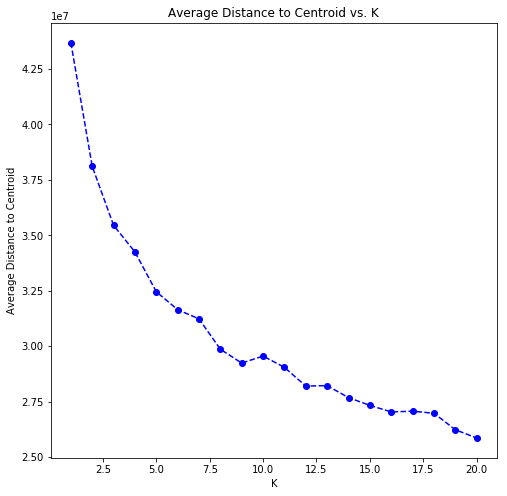

In [49]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
fig, ax = plt.subplots(figsize = (8,8))

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Average Distance to Centroid');
plt.title('Average Distance to Centroid vs. K');


In [50]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

center = 15
kmeans  = MiniBatchKMeans(center, batch_size = 1000, random_state = 10)
gen_predict = kmeans.fit_predict(data)

### Discussion 3.1: Apply Clustering to General Population

- We implement KMeans clustering with number of clusters varying from 1 to 20. We observe the average distance to the centroid decreases as the number of clusters increas.
- We take 15 as the number of centers to segment the population.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [51]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [52]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [53]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [54]:
# preprocessing
df_customer_clean = clean_data(customers) 
df_customer_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115643 entries, 0 to 115642
Data columns (total 76 columns):
ALTERSKATEGORIE_GROB     115643 non-null float64
ANREDE_KZ                115643 non-null float64
FINANZ_MINIMALIST        115643 non-null float64
FINANZ_SPARER            115643 non-null float64
FINANZ_VORSORGER         115643 non-null float64
FINANZ_ANLEGER           115643 non-null float64
FINANZ_UNAUFFAELLIGER    115643 non-null float64
FINANZ_HAUSBAUER         115643 non-null float64
GREEN_AVANTGARDE         115643 non-null float64
HEALTH_TYP               115643 non-null float64
RETOURTYP_BK_S           115643 non-null float64
SEMIO_SOZ                115643 non-null float64
SEMIO_FAM                115643 non-null float64
SEMIO_REL                115643 non-null float64
SEMIO_MAT                115643 non-null float64
SEMIO_VERT               115643 non-null float64
SEMIO_LUST               115643 non-null float64
SEMIO_ERL                115643 non-null float64
SEMIO_K

In [55]:
# Missmatching column
[ele for ele in list(df_clean.columns) if ele not in list(df_customer_clean.columns)]

['GEBAEUDETYP_5.0']

**There is no option 5.0 for 'GEBAEUDETYP' in customers data, so we add a column in customer data GEBAEUDETYP_5.0 with all zeros**

In [56]:
# Add one column 'GEBAEUDETYP_5.0' with all zeros in customer data
df_customer_clean.insert(76, 'GEBAEUDETYP_5.0', 0)

In [57]:
# Make the customer data have the same order of columns as general population data
df_customer_clean = df_customer_clean.reindex(columns=list(df_clean.columns))

In [58]:
# standard scaling
#ss_cust = StandardScaler()
scaled_df_customer = ss.fit_transform(df_customer_clean)

In [59]:
# pca transformation
scaled_df_customer_pca = pca_reapply.transform(scaled_df_customer)

In [60]:
# clustering prediction
customer_predict = kmeans.predict(scaled_df_customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

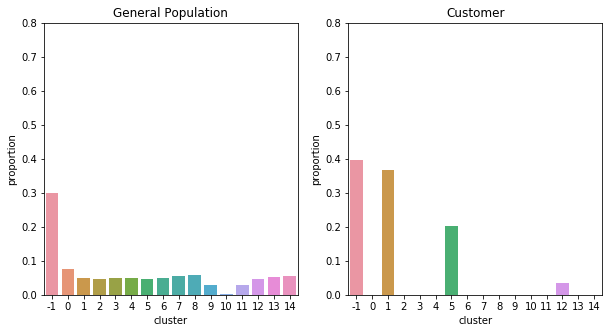

In [61]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def cluster_percent(predict, total_num,  n_clusters):
    missing_num = total_num - predict.shape[0]
    predict_add = np.append(predict, np.full(missing_num, -1))
    
    cluster = np.arange(-1,n_clusters)
    ele, counts = np.unique(predict_add, return_counts = True)
    results = dict(zip(ele, counts))
    
    proportion = []
    total_counts = counts.sum()
    for c in cluster:
        if c in ele:
            proportion.append(results[c]/total_counts)
        else:
            proportion.append(0)
    df_cluster = pd.DataFrame({'cluster': cluster,'proportion': proportion})
    return df_cluster

n_clusters = kmeans.n_clusters
total_gen = azdias.shape[0]
gen_cluster = cluster_percent(gen_predict, total_gen, n_clusters)


total_customer = customers.shape[0]
cust_cluster = cluster_percent(customer_predict, total_customer, n_clusters)


fig, axes = plt.subplots(1,2, figsize = (10,5))
sns.barplot( ax = axes[0], x = 'cluster',y = 'proportion', data = gen_cluster)
sns.barplot( ax = axes[1], x = 'cluster',y = 'proportion', data = cust_cluster)

titles = ['General Population', 'Customer']

for i, ax in enumerate(axes):
    ax.set_ylim(0,0.8) 
    ax.set_title(titles[i])


In [62]:
print('cluster in general population:\n {} \n cluster in customer:\n {}'.format(gen_cluster, cust_cluster))

cluster in general population:
     cluster  proportion
0        -1    0.300725
1         0    0.076425
2         1    0.049102
3         2    0.047436
4         3    0.050793
5         4    0.049201
6         5    0.046239
7         6    0.050817
8         7    0.055449
9         8    0.058339
10        9    0.027978
11       10    0.002724
12       11    0.028301
13       12    0.046615
14       13    0.053653
15       14    0.056203 
 cluster in customer:
     cluster  proportion
0        -1    0.396599
1         0    0.000000
2         1    0.367786
3         2    0.000000
4         3    0.000000
5         4    0.000000
6         5    0.201793
7         6    0.000000
8         7    0.000000
9         8    0.000000
10        9    0.000000
11       10    0.000000
12       11    0.000000
13       12    0.033822
14       13    0.000000
15       14    0.000000


In [70]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Clusters 1 and 5 are significantly overrepresented in cuttomer data.
cluster_interest = 1
ss.fit_transform(df_clean)
Centroid_over_data = ss.inverse_transform(pca_reapply.inverse_transform(kmeans.cluster_centers_[1])).reshape(1,77)
Centroid_over = pd.DataFrame(Centroid_over_data)
Centroid_over.columns = list(df_clean)
Centroid_over

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_5.0,GEBAEUDETYP_8.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,GENERATION,MOVEMENT,WEALTH,LIFESTAGE
0,3.434338,0.946901,3.625459,1.733971,4.403181,1.681086,1.665621,3.406044,0.050427,2.183713,...,-4.966315e-07,0.212173,0.259384,0.279091,0.264902,0.196622,62.489034,0.050427,3.682717,2.957991


In [71]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
#Clusters: 12

cluster_interest = 12

Centroid_under_data = ss.inverse_transform(pca_reapply.inverse_transform(kmeans.cluster_centers_[12])).reshape(1,77)
Centroid_under = pd.DataFrame(Centroid_under_data)
Centroid_under.columns = list(df_clean)
Centroid_under



,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_5.0,GEBAEUDETYP_8.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,GENERATION,MOVEMENT,WEALTH,LIFESTAGE
0,3.817738,0.083593,3.823509,1.321896,4.613012,2.452892,1.56716,3.29663,0.054077,1.794146,...,7.269818e-07,0.125194,0.076141,0.498373,0.06983,0.355655,60.133077,0.054077,2.626925,3.354103


In [72]:
over_under_df = feat_pca_max[['features_sort', 'Feature_name']]
principle_feature = list(over_under_df['features_sort'])
over_under_df['Centroid_9_Over'] = Centroid_over[principle_feature].values[0]
over_under_df['Centroid_14_Under'] = Centroid_under[principle_feature].values[0]
over_under_df['Values'] = ['1-6: high-low', '1-4: low-high', '1-2: low-high', '1-3: low-high',
                          '2-7: high-low', '40-90', '2-7: high-low', '1:<30, 2:<45, 3:<60, 4:>60', '2-7: high-low','2-7: high-low','2-7: high-low','1:male; 2:female' ]  
over_under_df


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,features_sort,Feature_name,Centroid_9_Over,Centroid_14_Under,Values
0,MOBI_REGIO,Movement patterns,2.548168,4.113423,1-6: high-low
1,PLZ8_ANTG1,Number of 1-2 family houses in the PLZ8 region,2.261041,2.947159,1-4: low-high
75,PLZ8_ANTG4,Number of 10+ family houses in the PLZ8 region,0.582899,0.161242,1-2: low-high
76,PLZ8_ANTG3,Number of 6-10 family houses in the PLZ8 region,1.642887,0.780526,1-3: low-high
0,SEMIO_REL,Personal religious typology(Affinity),3.652714,1.802024,2-7: high-low
1,GENERATION,Generation,62.489034,60.133077,40-90
75,SEMIO_ERL,Personal Event-oriented typology,4.326015,6.735830,2-7: high-low
76,ALTERSKATEGORIE_GROB,Estimated age based on given name analysis,3.434338,3.817738,"1:<30, 2:<45, 3:<60, 4:>60"
0,SEMIO_KAEM,Personal combative attitude typology,2.591365,5.290863,2-7: high-low
1,SEMIO_DOM,Personal dominant-minded typology,3.251431,5.104087,2-7: high-low


### Discussion 3.3: Compare Customer Data to Demographics Data

- The centroid of overrepresented and underrepresented clusters are listed above with the information of the feature_name and the values.

- The relatively popular segment of the population with the mail-order product tend to have:
    - **high** movement pattern, 
    - **low** affinity of religious typology (`SEMIO_REL`),
    - **medium** event-oriented typology (`SEMIO_ERL`), 
    - **high** combative attitude (`SEMIO_KAEM`) and dominant-minded (`SEMIO_DOM`),
    - **low** dreamful typology (`SEMIO_VERT`).

- The relatively unpopular segment of the population with the mail-order product tend to have:
    - **low** movement pattern, 
    - **high** affinity of religious typology (`SEMIO_REL`),
    - **low** event-oriented typology (`SEMIO_ERL`), 
    - **low** combative attitude (`SEMIO_KAEM`) and dominant-minded (`SEMIO_DOM`),
    - **high** dreamful typology (`SEMIO_VERT`).


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.